In [ ]:
# Install VELO SDK for easy API access
%pip install velo-sdk plotly pandas python-dotenv --quiet

Note: you may need to restart the kernel to use updated packages.

In [2]:
try:
    from google.colab import auth, userdata
    auth.authenticate_user()
    os.environ["RISKTHINKING_API_KEY"] = userdata.get("RISKTHINKING_API_KEY")
except:
    # Not in Colab or error retrieving secret; skip Colab-specific logic
    pass

In [1]:
import os

import pandas as pd
import plotly.express as px
import plotly.io as pio

from velo_sdk.api import APIClient

In [5]:
client = APIClient()  # VELO SDK auto detects $RISKTHINKING_API_KEY env var
company = client.companies.search_companies(name="Boeing", limit=1)[0]
company

Company(id='59d88a46-e160-406c-bac8-b8d9a8f26396', name='Boeing Co', slug='boeing-co', headquarters_address='929 Long Bridge Drive , Arlington, 22202, United States', organization_id=None, market_cap=103900000000, annual_revenue=66608000000, headquarters_country='US', sector='Industrials', isin_codes=['BRBOEIBDR003', 'ARDEUT110061', 'US0970231058', 'CA09702A1093'], figi_codes=[], cik_code='', lei_code='', stock_tickers=['BCO0', 'BAD', 'BACL', 'BA', 'BOEI34', '4BA', 'BOEB', 'BOE', 'BA *', 'BA_KZ', 'BAm', 'BCO'], is_grandparent=None, data_generated_at=None, data_generation_status=None, created_at='2025-02-14T00:19:59.501455', updated_at='2025-04-29T22:03:21.444843')

In [7]:
horizons = [2050]
pathway = "RT3"
metric = "cvar_95"

# Get factor scores for company assets
rows = []
for horizon in horizons:
    iterator = client.companies.list_company_asset_impact_scores(
        company_id=company.id, horizon=horizon, pathway=pathway, metric=metric
    )
    # iterator yields ((k1, asset_id), (k2, [ImpactScore,...]))
    for (_k1, asset_id), (_k2, impact_list) in iterator:
        for imp in impact_list:
            rows.append(
                {
                    "asset_id": asset_id,
                    "index_name": imp.index_name,
                    metric: imp.index_impact_cvar_95,
                    "horizon": horizon,
                    "pathway": pathway,
                }
            )
score_df = pd.DataFrame(rows)

# Get asset locations for company assets
assets = list(client.companies.list_company_assets(company.id))
assets = pd.DataFrame([vars(a) for a in assets])

# Join lat lon from assets to score_df
score_df = score_df.merge(
    assets[["id", "latitude", "longitude", "country"]],
    left_on="asset_id",
    right_on="id",
    how="left",
).drop(columns=["id"])

In [8]:
# choose an asset and grab the assets near by
asset_id = "5017a4d0-6972-4598-bdd4-562dbc651c95"

lat0, lon0 = score_df[score_df.asset_id == asset_id][["latitude", "longitude"]].values[
    0
]
delta = 0.5
lat_min, lat_max = lat0 - delta, lat0 + delta
lon_min, lon_max = lon0 - delta, lon0 + delta
within_box = score_df[
    (score_df["latitude"] >= lat_min)
    & (score_df["latitude"] <= lat_max)
    & (score_df["longitude"] >= lon_min)
    & (score_df["longitude"] <= lon_max)
]

In [9]:
# Label risk types for each asset
asset_risks = within_box.groupby("asset_id")["index_name"].apply(set).reset_index()


# Function to assign color based on risk types
def assign_color(risk_set):
    has_flood = "rflood_rp50" in risk_set
    has_fire = "fwi" in risk_set

    if has_flood and has_fire:
        return "purple"  # Both risks
    elif has_flood:
        return "blue"  # Only flood risk
    elif has_fire:
        return "red"  # Only fire risk
    else:
        return "green"  # No risk data


# Apply color assignment
asset_risks["color"] = asset_risks["index_name"].apply(assign_color)

# Merge with unique location data for each asset
unique_locations = within_box[["asset_id", "latitude", "longitude"]].drop_duplicates()
map_data = asset_risks.merge(unique_locations, on="asset_id", how="left")

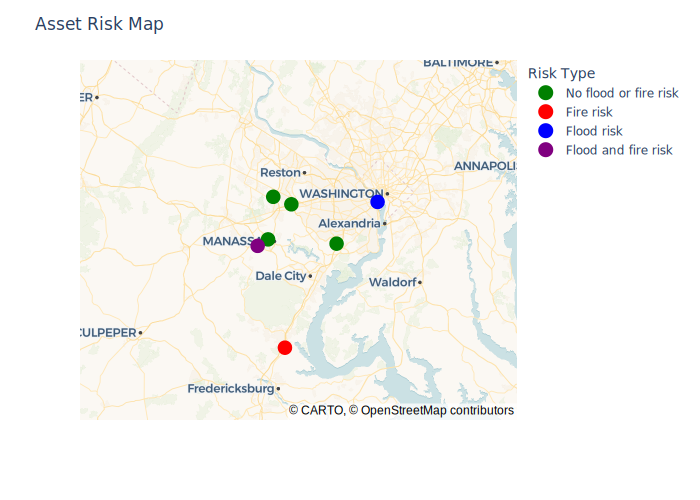

In [12]:
# Set the renderer to PNG for displaying in GitHub
pio.renderers.default = "svg"

# Create the map
fig = px.scatter_map(
    map_data,
    lat="latitude",
    lon="longitude",
    color="color",
    color_discrete_map={
        "blue": "blue",
        "red": "red",
        "purple": "purple",
        "green": "green",
    },
    zoom=7.5,
)

# Increase point size
fig.update_traces(marker={"size": 15})


# Update legend labels
for trace in fig.data:
    if trace.name == "blue":
        trace.name = "Flood risk"
    elif trace.name == "red":
        trace.name = "Fire risk"
    elif trace.name == "purple":
        trace.name = "Flood and fire risk"
    elif trace.name == "green":
        trace.name = "No flood or fire risk"


fig.update_layout(title="Asset Risk Map", showlegend=True, legend_title="Risk Type")
fig.show()